In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from utils.utils import make_writer
%matplotlib inline

# Most common bugs I

## Resources

- [Chapter 4 of Deep learning book. Numerical computation](https://www.deeplearningbook.org/contents/numerical.html)

## Incorrect tensor shapes

### Most common reasons:

- Flipped dimensions when using tf.reshape.
- Sum, avg, softmax over wrong dimension.
- Forgot to flatten after conv layers.
- Forgot to get rid of extra "1" dimensions, e.g. if shape is (None, 1, 1, 4).

- In TF2, as well as in other libraries, you can accidentally broadcast tensors and then it can fail silently or just output wrong results.

In [2]:
y_true = np.array([0.1, 0.7, 0.02, 0.08, 0.05, 0.05])
y_true_extra_dim = np.expand_dims(y_true, -1)
y_pred = np.array([0.1, 0.6, 0.05, 0.05, 0.1, 0.1])

In [3]:
print(f'y_true: {y_true} \n')
print(f'Shape of y_true: {y_true.shape} \n')
print(f'y_true_extra_dim: {y_true_extra_dim} \n')
print(f'Shape of y_true_extra_dim: {y_true_extra_dim.shape} \n')

y_true: [0.1  0.7  0.02 0.08 0.05 0.05] 

Shape of y_true: (6,) 

y_true_extra_dim: [[0.1 ]
 [0.7 ]
 [0.02]
 [0.08]
 [0.05]
 [0.05]] 

Shape of y_true_extra_dim: (6, 1) 



Say we want to divide y_true by y_pred. What shapes do we expect to get?

In [4]:
(y_true / y_pred).shape

(6,)

In [5]:
(y_true_extra_dim / y_pred).shape

(6, 6)

#### KL-divergence

KL-divergence is used in some models like VAEs or Bayesian models.

In [6]:
kl = tf.keras.losses.KLDivergence()

print(f'KLD for y_true: {kl(y_true, y_pred).numpy()} \n')
print(f'KLD for y_true_extra_dim: {kl(y_true_extra_dim, y_pred).numpy()}')

KLD for y_true: 0.05786523222923279 

KLD for y_true_extra_dim: 1.1752046346664429


## Pre-processing inputs incorrectly

- Forgot to standardize/scale.
    -  It makes the resulting model dependent on the choice of units used in the input.
- Too much augmentation.


### Regression example with Auto MPG data

#### Load the data and create a pandas DataFrame

In [7]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [8]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


- Drop NAs
- Drop categorical data for simplicity

In [9]:
dataset = dataset.dropna()
dataset.drop('Origin', axis=1, inplace=True)
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
0,18.0,8,307.0,130.0,3504.0,12.0,70
1,15.0,8,350.0,165.0,3693.0,11.5,70
2,18.0,8,318.0,150.0,3436.0,11.0,70
3,16.0,8,304.0,150.0,3433.0,12.0,70
4,17.0,8,302.0,140.0,3449.0,10.5,70


#### Plot the data

Let's plot 4 features.

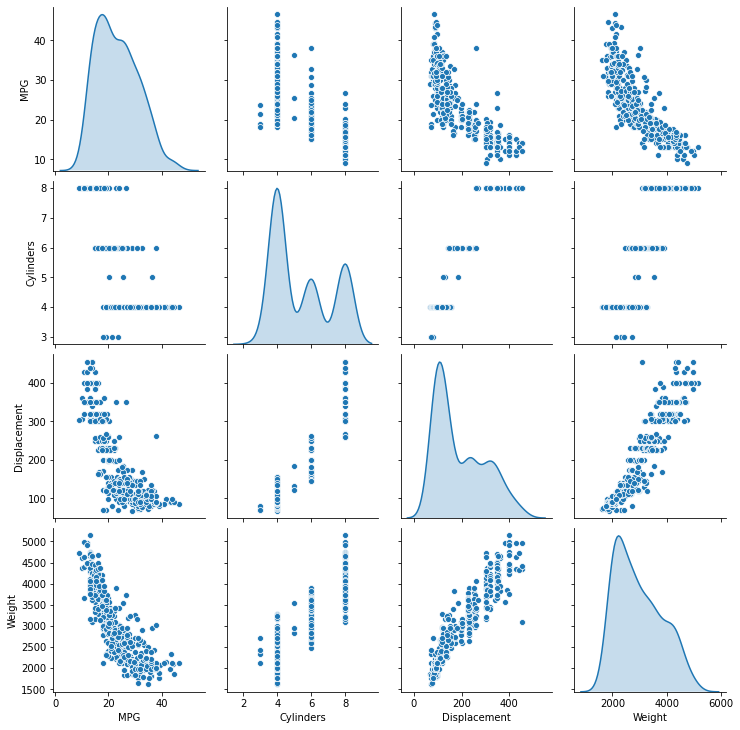

In [10]:
sns.pairplot(dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

We can also plot some statistics of the dataset.

In [11]:
stats = dataset.describe()
stats.pop('MPG')
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.0,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.0,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.5,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.5,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.0,79.000,82.0


### Create labels and train set

In [12]:
labels = dataset.pop('MPG')
labels = np.array(labels).astype('float32')

Let's make the difference in scales for some features even more pronounced.

In [13]:
dataset['Horsepower'] = dataset['Horsepower'] * 1000
dataset['Displacement'] = dataset['Displacement'] / 1000
train_set = np.array(dataset).astype('float32')

Let's plot the statistics again.

In [14]:
stats = dataset.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,392.0,5.471939,1.705783,3.000,4.000,4.000,8.00000,8.000
Displacement,392.0,0.194412,0.104644,0.068,0.105,0.151,0.27575,0.455
Horsepower,392.0,104469.387755,38491.159933,46000.000,75000.000,93500.000,126000.00000,230000.000
Weight,392.0,2977.584184,849.402560,1613.000,2225.250,2803.500,3614.75000,5140.000
Acceleration,392.0,15.541327,2.758864,8.000,13.775,15.500,17.02500,24.800
Model Year,392.0,75.979592,3.683737,70.000,73.000,76.000,79.00000,82.000


### Model

In [15]:
class RegressorNet(tf.keras.Model):
    
    def __init__(self, input_shape, optimizer):
        super(RegressorNet, self).__init__()
        
        self.optimizer = optimizer
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    
    def summary(self):
        self.regressor.summary()
    
    def call(self, X):
        return self.regressor(X)
    
    def get_loss(self, X, y_true):
        y_pred = self(X)
        l2_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
        return l2_loss
    
    def grad_step(self, X, y_true):
        with tf.GradientTape() as tape:
            loss = self.get_loss(X, y_true)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, gradients

In [16]:
optimizer = tf.keras.optimizers.Adam()
model = RegressorNet(input_shape=train_set.shape[1], optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


### Train and output to Tensorboard

In [26]:
def train(model, epochs, X, y, save_dir):
    
    writer = make_writer(os.path.join('summaries'), save_dir)
    
    for epoch in range(0, epochs + 1):
        
        if epoch % 100 == 0:
            print('Epoch {} is running...'.format(epoch))
            
        # Gradient update step
        loss, gradients = model.grad_step(X, y.reshape(-1, 1))
        loss = tf.math.reduce_mean(loss, axis=0)
        
        if epoch % 100 == 0:
            print(f'{loss}')
        
        # Tensorboard
        with writer.as_default():
            tf.summary.scalar('Train loss', loss, step=epoch)
            for layer_number in range(len(gradients)):
                if layer_number % 2 == 0:
                    tf.summary.histogram(f'{model.layers[0].layers[layer_number // 2].name}/kernel_0', \
                                         gradients[layer_number], step=epoch, buckets=1)
                else:
                    tf.summary.histogram(f'{model.layers[0].layers[(layer_number - 1) // 2].name}/bias_0', \
                                         gradients[layer_number], step=epoch, buckets=1)         


In [27]:
train(model, 1000, train_set, labels, 'scaling/regression__not_standard')

Creating a tensorboard directory: summaries/scaling/regression_unnorm
Epoch 0 is running...
80217030656.0
Epoch 100 is running...
669609.5
Epoch 200 is running...
22182.68359375
Epoch 300 is running...
22139.466796875
Epoch 400 is running...
22094.873046875
Epoch 500 is running...
22045.3671875
Epoch 600 is running...
21990.91796875
Epoch 700 is running...
21931.408203125
Epoch 800 is running...
21866.7890625
Epoch 900 is running...
21796.98046875
Epoch 1000 is running...
21721.94140625


### Excercise

- Write a function to standardize the data and apply it.
- Train with the new data for 1000 epochs and send the tensorboard output to a new directory.
- Why does the training depend so much on the scaling?


In [28]:
# Reinitialize the model instance
optimizer = tf.keras.optimizers.Adam()
model = RegressorNet(input_shape=train_set.shape[1], optimizer=optimizer)

In [29]:
# Write your code here:
def standardize(array):
    means = np.mean(array, axis=0)
    std = np.std(array, axis=0)
    return (array - means) /  std

In [30]:
stand_train_set = standardize(train_set)

In [31]:
train(model, 1000, stand_train_set, labels, 'scaling/regression_standard')

Creating a tensorboard directory: summaries/scaling/regression_norm
Epoch 0 is running...
609.9769287109375
Epoch 100 is running...
45.231849670410156
Epoch 200 is running...
18.751760482788086
Epoch 300 is running...
12.086714744567871
Epoch 400 is running...
9.6821928024292
Epoch 500 is running...
8.372286796569824
Epoch 600 is running...
7.6342573165893555
Epoch 700 is running...
7.130239009857178
Epoch 800 is running...
6.738390922546387
Epoch 900 is running...
6.427355766296387
Epoch 1000 is running...
6.178802013397217


## Incorrect input to the loss/ incorrect loss

- Softmaxed outputs to a loss that expects logits or vice-versa
- One-hot encoded labels to a sparse categorical cross-entropy loss
- ReLU in the last layer for regression problems
- E.g. MSE loss when categorical loss is expected

### MNIST example

In [26]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

In [28]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10)
            

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = MyModel()

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [30]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [31]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [32]:
EPOCHS = 5
writer = make_writer(os.path.join('summaries'), 'loss_bug/logits_false')

start = time.time()
for epoch in range(EPOCHS):

    train_loss.reset_states()
    train_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    
    with writer.as_default():
        tf.summary.scalar('Train Loss', train_loss.result(), step=epoch)
        tf.summary.scalar('Train Accuracy', train_accuracy.result() * 100, step=epoch)
    

    message = (f'Epoch: {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result() * 100}'
              )
    print(message)   

print(f'Time elapsed {time.time() - start}')

Creating a tensorboard directory: summaries/loss_bug/logits_false
Epoch: 1, Loss: 2.3114748001098633, Accuracy: 11.046667098999023
Epoch: 2, Loss: 2.3025569915771484, Accuracy: 11.051666259765625
Epoch: 3, Loss: 2.3025569915771484, Accuracy: 11.051666259765625
Epoch: 4, Loss: 2.3025569915771484, Accuracy: 11.051666259765625
Epoch: 5, Loss: 2.3025569915771484, Accuracy: 11.051666259765625
Time elapsed 419.48685002326965


### Tiny excercise

- Fix the loss above, rerun the cells and the training

In [33]:
EPOCHS = 5
writer = make_writer(os.path.join('summaries'), 'loss_bug/logits_true')

start = time.time()
for epoch in range(EPOCHS):

    train_loss.reset_states()
    train_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    
    with writer.as_default():
        tf.summary.scalar('Train Loss', train_loss.result(), step=epoch)
        tf.summary.scalar('Train Accuracy', train_accuracy.result() * 100, step=epoch)
    

    message = (f'Epoch: {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result() * 100}'
              )
    print(message)   

print(f'Time elapsed {time.time() - start}')

Creating a tensorboard directory: summaries/loss_bug/logits_true
Epoch: 1, Loss: 2.3025569915771484, Accuracy: 11.051666259765625
Epoch: 2, Loss: 2.3025569915771484, Accuracy: 11.051666259765625


KeyboardInterrupt: 